In [13]:
import sys
sys.path.append("/Users/yw11823/ACSE/irp/spyro")

import os
os.environ["OMP_NUM_THREADS"] = "1"

from firedrake import *
import numpy as np
import finat
from ROL.firedrake_vector import FiredrakeVector as FeVector
import ROL
from mpi4py import MPI
import psutil

import spyro
import time

import meshio
from SeismicMesh import *
import segyio


### Adjust the mesh size (resolution) using SeismicMesh with varying mesh sizes

In [2]:
import meshio
from SeismicMesh import *
import segyio

fname = "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/marmousi_exact.segy"
bbox = (-3500.0, 0.0, 0.0, 17000.0)
cpwl = 2.2 # 3.08 #2.22 #1.69 #$20 #7.02 #3.96 #2.67 #2.028
freq = 5.0
grade = 0.15
hmin = 1500 / (cpwl * freq)
pad = 4500.0 / freq  # cmax / freq
###########
rectangle = Rectangle(bbox)
ef = get_sizing_function_from_segy(
    fname,
    bbox,
    hmin=hmin,
    wl=cpwl,
    freq=freq,
    grade=grade,
    domain_pad=pad,
    pad_style="edge",
    units="m-s",
)

write_velocity_model(
    fname,
    ofname="velocity_models/marmousi_exact",
    bbox=bbox,
    domain_pad=pad,
    pad_style="edge",
    units="m-s",
)
points, cells = generate_mesh(domain=rectangle, edge_length=ef, verbose=2)
meshio.write_points_cells("meshes/marmousi_exact.vtk", points / 1000.0, [("triangle", cells)])
meshio.write_points_cells(
    "meshes/marmousi_exact.msh",
    points / 1000.0,
    [("triangle", cells)],
    file_format="gmsh22",
    binary=False,
)

Mesh sizes will be built to resolve an estimate of wavelength of a 5.0  hz wavelet with 2.2 vertices
Enforcing minimum edge length of 136.36363636363637
Enforcing maximum edge length of 10000.0
Enforcing mesh size gradation of 0.15 decimal percent...
Including a 900.0 meter domain extension...
Using the pad_style: edge
Adding a domain pad to the velocity model...
Including a 900.0 meter domain extension...
Using the pad_style: edge
Writing velocity model: velocity_models/marmousi_exact.hdf5
Constraining 2 fixed points...
Commencing mesh generation with 2550 vertices on rank 0.
Iteration #1, max movement is 411.045924, there are 2550 vertices and 4934 cells
     Elapsed wall-clock time 0.052763 : 
Iteration #2, max movement is 164.952578, there are 2550 vertices and 4897 cells
     Elapsed wall-clock time 0.046792 : 
Iteration #3, max movement is 118.918759, there are 2550 vertices and 4893 cells
     Elapsed wall-clock time 0.035245 : 
Iteration #4, max movement is 119.060595, there ar

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

### Plot shot-record in the same way as Devito

In [14]:
import numpy as np
try:
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    mpl.rc('font', size=16)
    mpl.rc('figure', figsize=(8, 6))
except:
    plt = None
    cm = None
    
def plot_shotrecord(rec, model, t0, tn, colorbar=True):
    """
    Plot a shot record (receiver values over time).

    Parameters
    ----------
    rec :
        Receiver data with shape (time, points).
    model : Model
        object that holds the velocity model.
    t0 : int
        Start of time dimension to plot.
    tn : int
        End of time dimension to plot.
    """
    scale = np.max(rec) / 10.0
    extent = [0, model["mesh"]["Lx"],
              model["timeaxis"]["tf"], model["timeaxis"]["t0"] ]


    plot = plt.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
    plt.xlabel('X position (km)')
    plt.ylabel('Time (s)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()

# Example 1: circle - spyro - forward
## 1.1 Construct the model
1 sources

101 receivers

mesh $1.0km \times 1.0km$

pml = 0.4 km 

Ricker : feq = 10 HZ 

tf = 1s, dt=0.0005s

p_order = 4, suggested

In [23]:
sou_pos = [(0.02, 0.5)]
rec_pos = spyro.create_transect((0.98, 0.0), (0.98, 1.0), 101)

model = {}
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV",  # Equi or KMV
    "degree": 2,  # p order
    "dimension": 2,  # dimension
    # "regularization": False,  # regularization is on?
    # "gamma": 1.0,  # regularization parameter
}
model["parallelism"] = {
    "type": "spatial", 
}
model["mesh"] = {
    "Lz": 1.0,  # depth in km - always positive
    "Lx": 1.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh", 
    "initmodel": "not_used.hdf5", 
    "truemodel": "not_used.hdf5", 
}
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.4,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.4,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker", 
    "source_pos": sou_pos, 
    "frequency": 10.0, 
    # "delay": 0.1, 
    "delay": 0.1, 
    "receiver_locations": rec_pos, 
}
model["timeaxis"] = {
    "t0": 0.0,  # Initial time for event
    "tf": 1.00,  # Final time for event
    # "dt": 0.0004082,  # to match the dt.critical in Devito
    "dt": 0.0005,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 1,  # how frequently to save solution to RAM
    "skip": 4,
}


# mesh = RectangleMesh(101, 101, 1.0, 1.0) # size of the mesh: 1 x 1 km
# mesh = PeriodicRectangleMesh(200, 200,1,1) # this is not workable in the current case
mesh = UnitSquareMesh(100, 100) # 1000 cells in x-direction and The number of cells in the y direction = 1000


comm = spyro.utils.mpi_init(model)
element = spyro.domains.space.FE_method(mesh, model["opts"]["method"], model["opts"]["degree"])
V = FunctionSpace(mesh, element)

# Create a simple two-layer seismic velocity model `vp`.
x, y = SpatialCoordinate(mesh)
radius = 0.3
center_x, center_y = 0.5, 0.5
condition = (x - center_x)**2 + (y - center_y)**2 < radius**2
velocity = conditional(condition, 3.0, 2.5)
vp = Function(V, name="velocity").interpolate(velocity)
File("true_velocity_model_circle.pvd").write(vp)

sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

d0=model["timeaxis"]["t0"]
dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq)

# Calculate running time
start_time = time.time()
p_field, p_at_recv = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


Simulation time is:     0.0495 seconds
Simulation time is:     0.0995 seconds
Simulation time is:     0.1495 seconds
Simulation time is:     0.1995 seconds
Simulation time is:     0.2495 seconds
Simulation time is:     0.2995 seconds
Simulation time is:     0.3495 seconds
Simulation time is:     0.3995 seconds
Simulation time is:     0.4495 seconds
Simulation time is:     0.4995 seconds
Simulation time is:     0.5495 seconds
Simulation time is:     0.5995 seconds
Simulation time is:     0.6495 seconds
Simulation time is:     0.6995 seconds
Simulation time is:     0.7495 seconds
Simulation time is:     0.7995 seconds
Simulation time is:     0.8495 seconds
Simulation time is:     0.8995 seconds
Simulation time is:     0.9495 seconds
Running Time: 37.92 seconds


## something about meshing

In [25]:
# help(firedrake.utility_meshes)

In [ ]:
# # example of 1d mesh
# mesh = IntervalMesh(10, 0.0, 1.0)

# mesh

# mesh = UnitIntervalMesh(10)

# mesh

Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 28355)

In [ ]:
# # example of 2d mesh
# mesh = RectangleMesh(101,101, 10, 20)
# mesh

# mesh = UnitSquareMesh(1000, 1000) # 1000 cells in x-direction and The number of cells in the y direction = 1000
# mesh

# mesh = PeriodicRectangleMesh(100, 100,1,1)
# mesh

# mesh = RectangleMesh(100, 100, 1,1) # (nx, ny, lx, ly)
# mesh

In [ ]:
# # examples of 3d mesh
# mesh = BoxMesh(100, 100, 100, 10, 10, 10)
# mesh

# mesh = UnitCubeMesh(10, 10, 10)
# mesh

Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 28358)

In [9]:
len(p_field) # This means we saved the p_field every 1ms.


1000

## 1.2. Construct the mesh, acquisition geometry (receiver location, source location, and wavelet)
## 1.3. Applying forward method and measure running time. & Plot the shot record. & Save data.

##  p_at_recv is the shot record data
len = (tf - t0) / dt

len(p_field) = (tf - t0) / （dt * fspool）

In [17]:
p_at_recv # this depends on (tf - t0 ) /dt

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.52534533e-06, 5.35994819e-06, 5.03160727e-06, ...,
        4.96486912e-06, 5.30661181e-06, 5.49130022e-06],
       [5.51177381e-06, 5.30699345e-06, 4.94494009e-06, ...,
        4.87562674e-06, 5.25145949e-06, 5.47510522e-06],
       [5.49304069e-06, 5.25016466e-06, 4.85642486e-06, ...,
        4.78534270e-06, 5.19306614e-06, 5.45398398e-06]])

For very high resolution : t = 0.00005 
p_at_recv =
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.31512110e-06, 4.95308911e-06, 4.49363519e-06, ...,
        4.46789904e-06, 4.92202401e-06, 5.28130663e-06],
       [5.31142764e-06, 4.94633424e-06, 4.48472951e-06, ...,
        4.45903700e-06, 4.91534413e-06, 5.27768061e-06],
       [5.30768819e-06, 4.93954811e-06, 4.47580973e-06, ...,
        4.45017441e-06, 4.90864333e-06, 5.27400975e-06]])

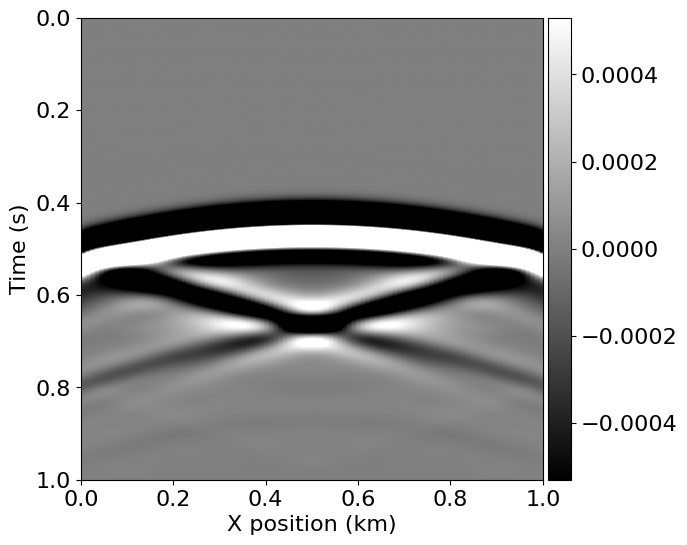

In [26]:
import matplotlib.pyplot as plt

# Plot shot record for true and smooth velocity model and the difference
# plt.title('Shot record - true vel_t=0.00005', loc='right')
plot_shotrecord(p_at_recv, model, d0, tf) # In reality, this would be our data from the experiment

In [27]:
p_field[0].ufl_domain()

Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 6585)

In [28]:
p_field[10].dat.data.shape

(60401,)

In [29]:
p_field[10].dat.data

array([0., 0., 0., ..., 0., 0., 0.])

lengh of p_field (total time steps): 2000
time in ms: 40
dt: 0.0005


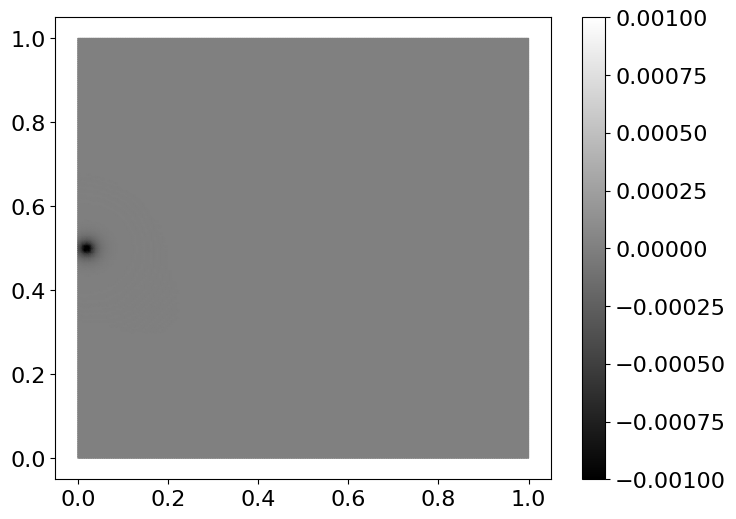

In [54]:
import firedrake as fd
print("lengh of p_field (total time steps):", len(p_field))
t1 = 0
print("time in ms:", int(t1 * dt * 1000) )
print("dt:", dt)
fig = fd.tripcolor(p_field[time], cmap="gray", vmin=-1e-3, vmax=1e-3)  # 绘制压力场
plt.colorbar(fig)

In [22]:
dt

0.0005

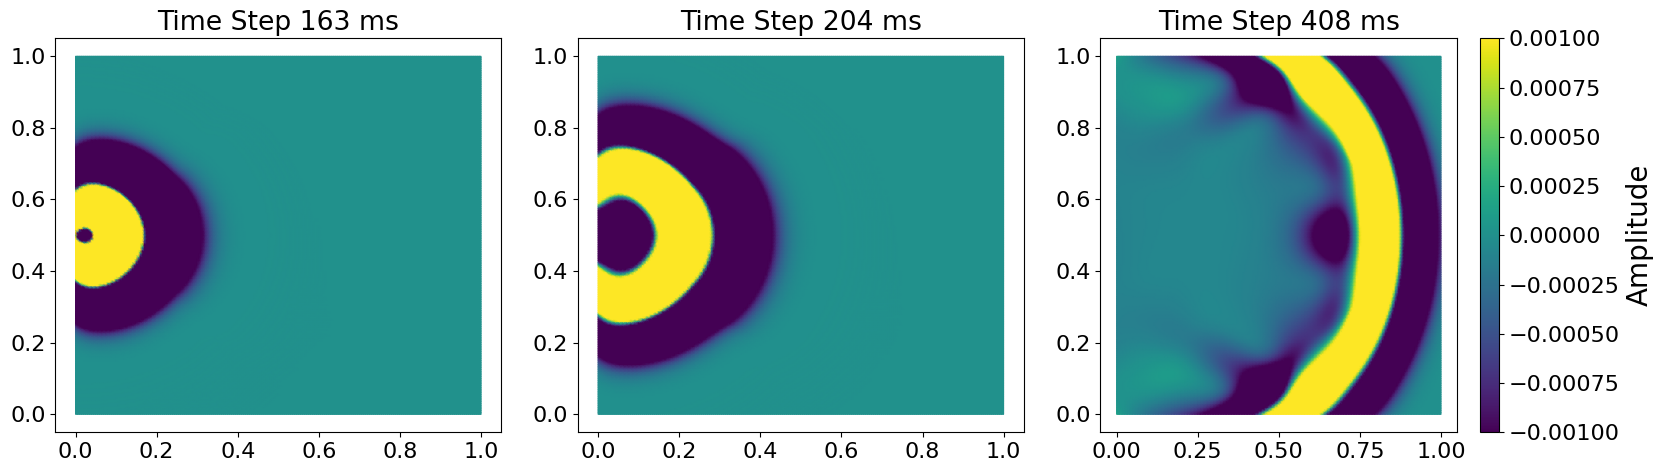

In [47]:
import matplotlib.pyplot as plt
import firedrake as fd

# # 80 * 12
# # correspinding to the time steps in Devito 
# time_steps_devito = [80,10, 20]
# time_steps = [t * 12 for t in time_steps_devito]
# dt = model["timeaxis"]["dt"]
# scaled_time_steps = [int(t * dt * 1000 *2)  for t in time_steps]

time_steps = [326, 408 ,816]
time_taken = [int(t * dt * 1000 )  for t in time_steps] # converge s to ms
fig, axes = plt.subplots(1, 3, figsize=(17,5))

# 遍历每个时间步和对应的轴
for ax, t_index, t_time in zip(axes, time_steps, time_taken):
    colors = fd.tripcolor(p_field[t_index], axes=ax, vmin=-1e-3, vmax=1e-3)  # 绘制压力场
    ax.set_title(f"Time Step {t_time} ms")  # 设置子图标题

# 指定colorbar使用的是im2的颜色映射
cbar = fig.colorbar(colors, )  # 为所有子图添加统一的颜色条
cbar.set_label('Amplitude', fontsize=20)

plt.tight_layout()  # 调整布局以避免重叠
plt.show()

In [126]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import firedrake as fd

# 设置图形和动画的参数
fig, ax = plt.subplots(figsize=(5, 5))
cmap = 'grey'  # 选择一个颜色映射

# 初始化图像显示
frame = fd.tripcolor(p_field[0], axes=ax, cmap=cmap)
ax.set_title('Time Step: 0')
colorbar = fig.colorbar(frame, ax=ax)

# 更新函数，用于动画
def update(frame_number):
    ax.clear()
    frame = fd.tripcolor(p_field[frame_number], axes=ax, cmap=cmap)
    ax.set_title(f'Time Step: {frame_number}')
    return frame,

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=range(0, 999), blit=False, repeat=False)

# 显示动画
plt.close(fig)  # 避免显示静态图
HTML(ani.to_html5_video())


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105842150>>
Traceback (most recent call last):
  File "/Users/yw11823/ACSE/irp/firedrake/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


<Figure size 1000x500 with 0 Axes>

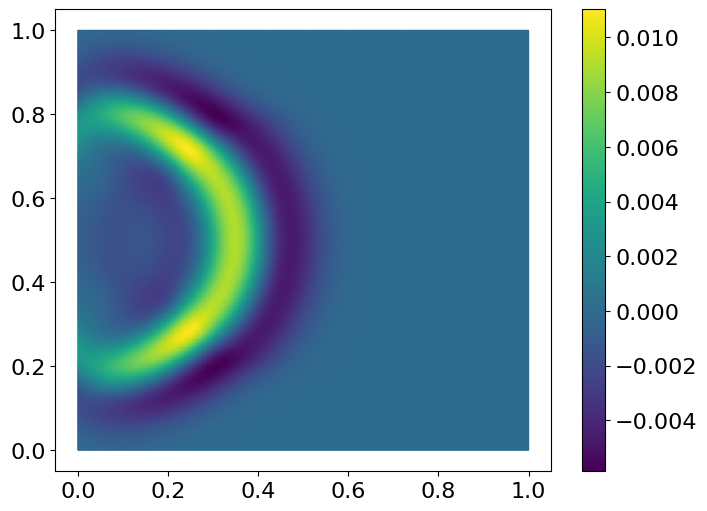

In [104]:
import matplotlib.pyplot as plt
import firedrake as fd

# Suppose 'pressure' is your Firedrake Function containing the pressure field
# Let's assume it's a 2D simulation for simplicity

# Create a plot figure
plt.figure(figsize=(10, 5))

# Using Firedrake's tripcolor for plotting FEM function data
colors = fd.tripcolor(p_field[5], cmap="viridis")  
plt.colorbar(colors)  # 添加颜色条

In [49]:
# import matplotlib.pyplot as plt
# from matplotlib.tri import Triangulation, tripcolor

# # 计算需要显示的时间步索引
# time_steps = list(range(0, len(p_field), 50))
# # 创建多个子图
# fig, axes = plt.subplots(1, len(time_steps), figsize=(15, 3)) # 调整 figsize 以适合你的显示需求
# # 绘制每个时间步的压力场
# for ax, t in zip(axes, time_steps):
#     colors = tripcolor(p_field[t], axes=ax, cmap='viridis')
#     ax.set_title(f"Pressure Field at t={t}")
#     plt.colorbar(colors, ax=ax)  # 为每个子图添加颜色条

# for t in time_steps:
#     print(f"Type of p_field[{t}]: {type(p_field[t])}")

# plt.tight_layout()  # 自动调整子图参数，以给定填充的整个图形区域
# plt.show()

In [ ]:
spyro.io.save_shots(model, comm, p_field, file_name = "C_filed")

# Q: See the difference between "source_num = 0" and "source_num = 10" when calling the forward function.
## But there is no difference???? WHY??

In [277]:
p_field, p_at_recv_10 = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers, source_num = 10)
p_at_recv - p_at_recv_10

Simulation time is:     0.0495 seconds
Simulation time is:     0.0995 seconds
Simulation time is:     0.1495 seconds
Simulation time is:     0.1995 seconds
Simulation time is:     0.2495 seconds
Simulation time is:     0.2995 seconds
Simulation time is:     0.3495 seconds
Simulation time is:     0.3995 seconds
Simulation time is:     0.4495 seconds
Simulation time is:     0.4995 seconds
Simulation time is:     0.5495 seconds
Simulation time is:     0.5995 seconds
Simulation time is:     0.6495 seconds
Simulation time is:     0.6995 seconds
Simulation time is:     0.7495 seconds
Simulation time is:     0.7995 seconds
Simulation time is:     0.8495 seconds
Simulation time is:     0.8995 seconds
Simulation time is:     0.9495 seconds


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 1.4 Shot record
## (1) Between different velocity model
## Smooth the velocity

In [ ]:
# Create a simple two-layer seismic velocity model `vp`.
x, y = SpatialCoordinate(mesh)
radius = 0.3
center_x, center_y = 0.5, 0.5
condition = (x - center_x)**2 + (y - center_y)**2 < radius**2
velocity_smoothed = conditional(condition, 2.5, 2.5)
vp_smoothed = Function(V, name="velocity").interpolate(velocity_smoothed)
File("initial_velocity_model_circle.pvd").write(vp_smoothed)

# Calculate running time
start_time = time.time()
p_field_smoothed, p_at_recv_smoothed = spyro.solvers.forward(model, mesh, comm, vp_smoothed, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Plot the shot record using the function written in Spyro
spyro.plots.plot_shots(model, comm, p_at_recv_smoothed, file_name = "C_smoothed")
# Save data in the shots folder
spyro.io.save_shots(model, comm, p_at_recv_smoothed, file_name = "C_smoothed")

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


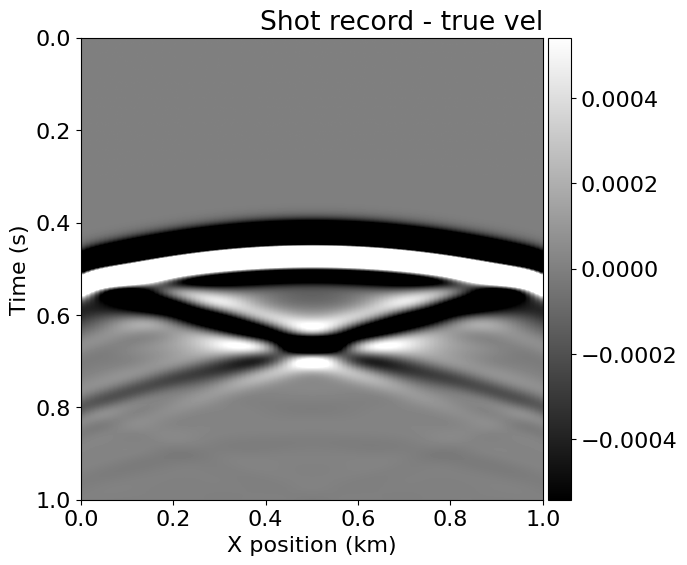

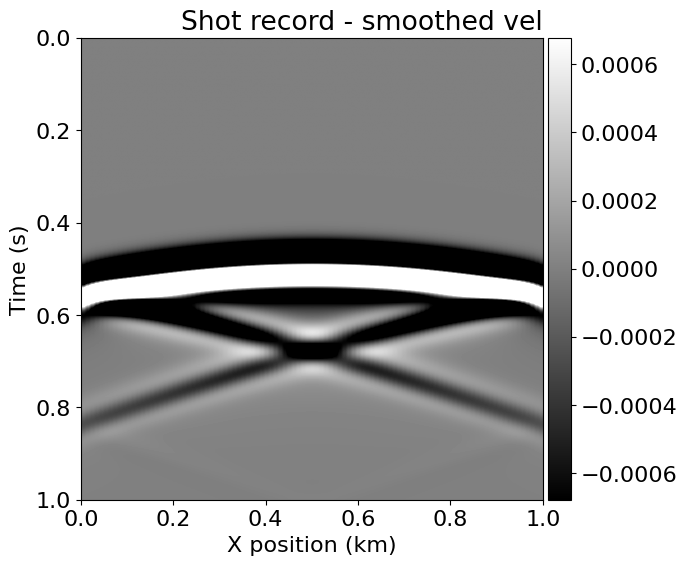

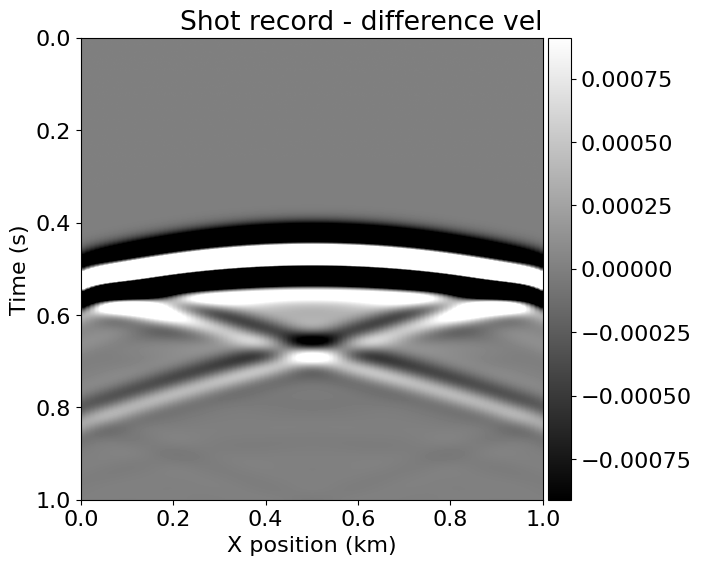

In [286]:
# Plot shot record for true and smooth velocity model and the difference
plt.title('Shot record - true vel', loc='right')
plot_shotrecord(p_at_recv, model, d0, tf) # In reality, this would be our data from the experiment
plt.title('Shot record - smoothed vel', loc='right')
plot_shotrecord(p_at_recv_smoothed, model, d0, tf) # This is our model data
plt.title('Shot record - difference vel', loc='right')
plot_shotrecord(p_at_recv - p_at_recv_smoothed, model, d0, tf) # This is the data residual

### Other visualizations
There are difference between p_field[0] and p_filed[10]

Using imshow shot record directly

Plot the wavelet

Plot the p_filed[]

Plot the position of source and receiver

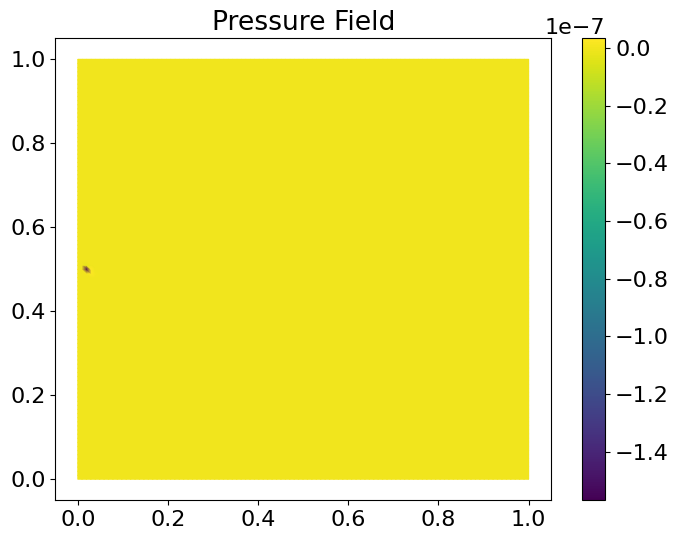

In [338]:
# # 比较缩放后的数据
# plt.figure()
# plt.imshow(p_at_recv, cmap='gray', aspect='auto')
# plt.colorbar()
# plt.title('Devito Data')
# plt.show()

# # plot p_filed
# p_field
# fig, axes = plt.subplots()
# colors = tripcolor(p_field[0], axes=axes, cmap='viridis')
# plt.colorbar(colors)  # 添加颜色条
# axes.set_title("Pressure Field")
# plt.show()

# # plot the graph of the source wavelets
# wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq)
# plt.figure(figsize=(8, 5))
# plt.plot( wavelet, color='blue', linewidth=1.5, label=f'Ricker Wavelet (Freq={freq} Hz)')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # plot the position of source and receiver
# # Plotting
# fig, ax = plt.subplots()
# ax.plot(*zip(*sou_pos), 'ro', label='Source')  # red dot for source
# ax.plot(*zip(*rec_pos), 'bs', label='Receivers')  # blue squares for receivers
# # Setting the axis limits to match the example
# ax.set_xlim(0, 1.0)
# ax.set_ylim(0, 1.0)
# # Adding labels
# ax.set_xlabel('X position')
# ax.set_ylabel('Y position')
# ax.set_title('Source and Receiver Positions')
# plt.show()

# print(d0)
# print(dt)
# print(tf)
# print(freq)

## (2) Between different mesh (resolution) 
## Different mesh resolution this one i used the varied traigular mesh

In [320]:
# mesh = UnitSquareMesh(100, 100, 1.0, 1.0)
mesh = RectangleMesh(51, 51, 1.0, 1.0)
# mesh.coordinates.dat.data[:, 0] -= 0.25 将x坐标向左平移0.25个单位
# mesh.coordinates.dat.data[:, 1] -= 1.25 将y坐标向下平移1.25个单位

comm = spyro.utils.mpi_init(model)
element = spyro.domains.space.FE_method(mesh, model["opts"]["method"], model["opts"]["degree"])
V = FunctionSpace(mesh,element)

# Create a simple two-layer seismic velocity model `vp`.
x, y = SpatialCoordinate(mesh)
radius = 0.3
center_x, center_y = 0.5, 0.5
condition = (x - center_x)**2 + (y - center_y)**2 < radius**2
velocity = conditional(condition, 3.0, 2.5)
vp = Function(V, name="velocity").interpolate(velocity)
File("true_velocity_model_circle_lowresol.pvd").write(vp)

sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

d0=model["timeaxis"]["t0"]
dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet( dt= dt, tf = tf, freq= freq,)

# Calculate running time
start_time = time.time()
p_field, p_at_recv_lowresol = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Plot the shot record using the function written in Spyro
spyro.plots.plot_shots(model, comm, p_at_recv, file_name = "C_lowresol")
# Save data in the shots folder
spyro.io.save_shots(model, comm, p_at_recv, file_name = "C_lowresol")

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


Simulation time is:     0.0495 seconds
Simulation time is:     0.0995 seconds
Simulation time is:     0.1495 seconds
Simulation time is:     0.1995 seconds
Simulation time is:     0.2495 seconds
Simulation time is:     0.2995 seconds
Simulation time is:     0.3495 seconds
Simulation time is:     0.3995 seconds
Simulation time is:     0.4495 seconds
Simulation time is:     0.4995 seconds
Simulation time is:     0.5495 seconds
Simulation time is:     0.5995 seconds
Simulation time is:     0.6495 seconds
Simulation time is:     0.6995 seconds
Simulation time is:     0.7495 seconds
Simulation time is:     0.7995 seconds
Simulation time is:     0.8495 seconds
Simulation time is:     0.8995 seconds
Simulation time is:     0.9495 seconds
Running Time: 12.13 seconds


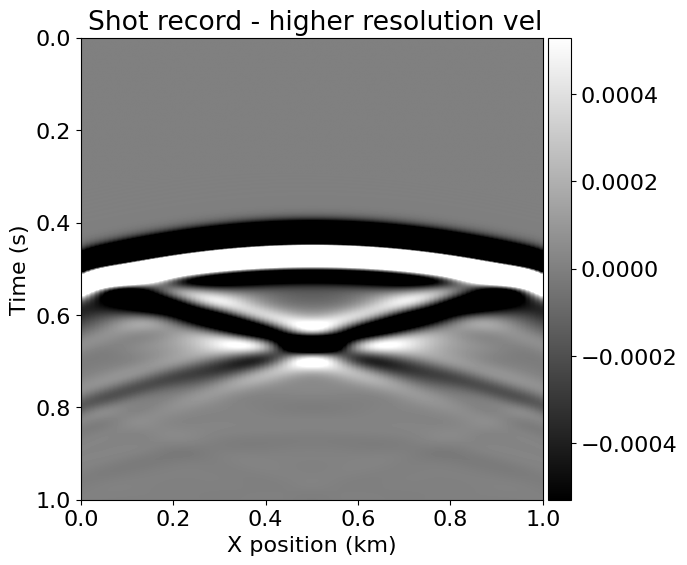

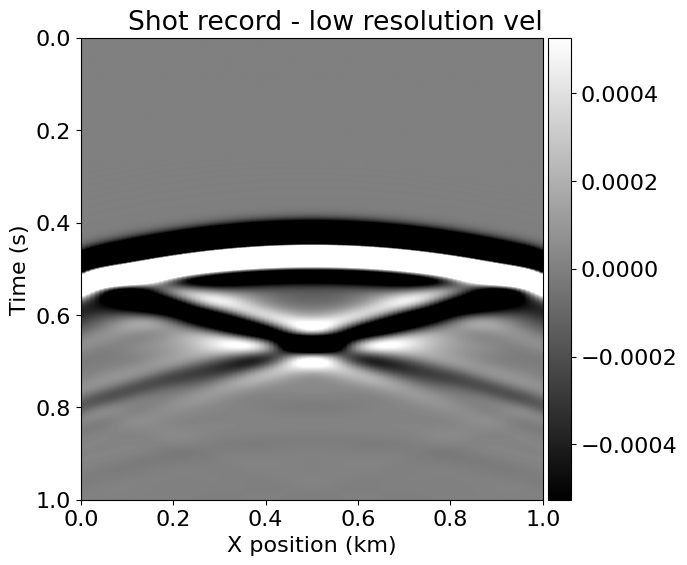

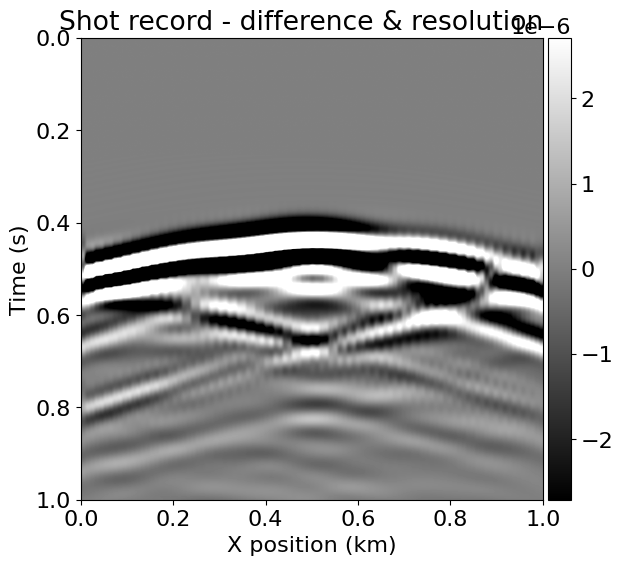

In [321]:
plt.title('Shot record - higher resolution vel', loc='right')
plot_shotrecord(p_at_recv, model, d0, tf) 
plt.title('Shot record - low resolution vel', loc='right')
plot_shotrecord(p_at_recv_lowresol, model, d0, tf) 
plt.title('Shot record - difference & resolution', loc='right')
plot_shotrecord(p_at_recv_lowresol - p_at_recv, model, d0, tf) 

# Example2: marmousi(2d) - spyro - forward - guess (smoothed) - fwi
## 2.1. set up the model 
3 sources

101 receivers

mesh $3.5km \times 10.0km$

pml = 0.9 km 

Ricker : feq = 5 

tf = 2s, dt=0.001s

In [288]:
number_sou = 3
number_rec = 101
sou = spyro.create_transect((-0.01, 1.0), (-0.01, 15.0), 3) # in km
rev = spyro.create_transect((-0.10, 0.1), (-0.10, 17.0), 101)  # in km

model = {}
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV",  # Equi or KMV
    "degree": 4,  # p order
    "dimension": 2,  # dimension
    "regularization": False,  # regularization is on?
    "gamma": 1.0,  # regularization parameter
}
model["parallelism"] = {
    # "type": "automatic",
    "type": "spatial",
}
model["mesh"] = {
    "Lz": 3.5,  # depth in km - always positive - z position
    "Lx": 10.0,  # width in km - always positive - x position
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/meshes/marmousi_guess.msh",
    "initmodel": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_guess.hdf5",
    "truemodel": "not_used.hdf5",
}
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker",  # Specify the type of source, here a "Ricker" wavelet is used
    "num_sources": number_sou,  # The number of sources in the acquisition
    "source_pos": sou,  # Array or list of source positions
    "frequency": 5.0,  # The dominant frequency of the source wavelet in Hz
    "delay": 1.0,  # Delay in seconds before the source starts
    "num_receivers": number_rec,  # The number of receivers in the acquisition
    "receiver_locations": rev,  # Array or list of receiver locations
}
model["timeaxis"] = {
    "t0": 0.0,  # Initial time for event
    "tf": 2.00,  # Final time for event
    "dt": 0.001,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 1000,  # how frequently to output solution to pvds
    "fspool": 99999,  # how frequently to save solution to RAM
    "skip": 4,
}

## 2.2. Construct the mesh, acquisition geometry (receiver location, source location, and wavelet)
## 2.3. Apllying forward method and measure running time. & Plot the shot record. & Save data.

In [289]:
comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)
if COMM_WORLD.rank == 0:
    print(f"The mesh has {V.dim()} degrees of freedom")
vp = spyro.io.interpolate(model, mesh, V, guess=True)
if comm.ensemble_comm.rank == 0:
    File("guess_velocity_2d.pvd", comm=comm.comm).write(vp)
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

d0=model["timeaxis"]["t0"]
dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet(dt=dt,tf=tf,freq=freq,)

# Calculate runnning time
start_time = time.time()
p_guess, p_r_guess = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Plot the shot record using the function written in Spyro
spyro.plots.plot_shots(model, comm, p_at_recv_smoothed = "M2d_guess")
# Save data in the shots solder
spyro.io.save_shots(model, comm, p_r_guess, file_name = "M2d_guess")

INFO: Distributing 3 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 9714 elements and can access 5022 vertices
The mesh has 29471 degrees of freedom


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


INFO: converting from m/s to km/s


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value)._

Simulation time is:      0.999 seconds
Running Time: 34.84 seconds


# Q: See the difference between "source_num = 0" and "source_num = 10" when calling the forward function.
## But there is no difference???? WHY?? and the shot_record is weird

In [293]:
p_field, p_r_guess_10 = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers, source_num = 10)

/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "


Simulation time is:      0.999 seconds


In [294]:
p_r_guess_10 - p_r_guess

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

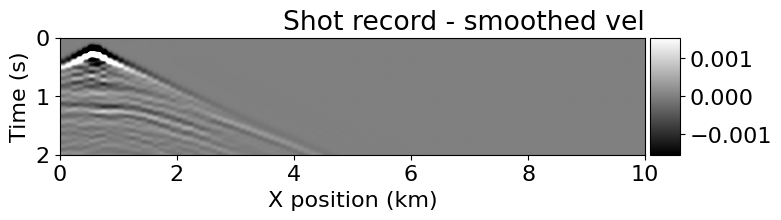

In [295]:
plt.title('Shot record - smoothed vel', loc='right')
plot_shotrecord(p_r_guess, model, d0, tf) # In reality, this would be our data from the experiment

# 2.4 Marmousi - spyro - 2d - forward - true
## 2.4.1. set up the model 
3 sources

101 receivers

mesh $3.5km \times 10.0km$

pml = 0.9 km 

Ricker : feq = 5 

tf = 2s, dt=0.00025s

In [296]:
number_sou = 3
number_rec = 101
sou = spyro.create_transect((-0.01, 1.0), (-0.01, 15.0), 3) # in km
rev = spyro.create_transect((-0.10, 0.1), (-0.10, 17.0), 101)  # in km

model = {}

model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV",  # Equi or KMV
    "degree": 5,  # p order
    "dimension": 2,  # dimension
}
model["parallelism"] = {
    "type": "spatial",
}
model["mesh"] = {
    "Lz": 3.5,  # depth in km - always positive
    "Lx": 10.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/meshes/marmousi_exact.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5",
}
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": number_sou,
    "source_pos": sou,
    "frequency": 5.0,
    "delay": 1.0,
    "num_receivers": number_rec,
    "receiver_locations": rev,
}
model["timeaxis"] = {
    "t0": 0.0,  # Initial time for event
    "tf": 2.00,  # Final time for event
    "dt": 0.00025,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 99999,  # how frequently to save solution to RAM
}

## 2.4.2. Construct the mesh, acquisition geometry (receiver location, source location, and wavelet)
## 2.4.3. Apllying forward method and measure running time. & Plot the shot record. & Save data.

In [328]:
comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)
vp = spyro.io.interpolate(model, mesh, V, guess=False)
if comm.ensemble_comm.rank == 0:
    File("true_velocity.pvd", comm=comm.comm).write(vp)
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet(dt=dt,tf=tf,freq=freq,)

start_time = time.time()
p, p_r = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Plot the shot record using the function written in Spyro
spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-5, vmax=1e-5, file_name="M2d_true")
# spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-3, vmax=1e-3)
spyro.io.save_shots(model, comm, p_r, file_name="M2d_true")

INFO: Distributing 3 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 4866 elements and can access 2550 vertices


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


INFO: converting from m/s to km/s


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value)._

Simulation time is:    0.02475 seconds
Simulation time is:    0.04975 seconds
Simulation time is:    0.07475 seconds
Simulation time is:    0.09975 seconds
Simulation time is:     0.1247 seconds
Simulation time is:     0.1497 seconds
Simulation time is:     0.1748 seconds
Simulation time is:     0.1998 seconds
Simulation time is:     0.2248 seconds
Simulation time is:     0.2497 seconds
Simulation time is:     0.2747 seconds
Simulation time is:     0.2998 seconds
Simulation time is:     0.3247 seconds
Simulation time is:     0.3498 seconds
Simulation time is:     0.3748 seconds
Simulation time is:     0.3997 seconds
Simulation time is:     0.4248 seconds
Simulation time is:     0.4497 seconds
Simulation time is:     0.4748 seconds
Simulation time is:     0.4998 seconds
Simulation time is:     0.5248 seconds
Simulation time is:     0.5497 seconds
Simulation time is:     0.5747 seconds
Simulation time is:     0.5998 seconds
Simulation time is:     0.6248 seconds
Simulation time is:     0

# Q : WHY the shot_record_1.dat is exactly the same as shot_reocrd_2.dat????
does this because i was using the serial running instead of parallel?

there is no difference even if i set the source_num in forward function

In [ ]:
start_time = time.time()
p, p_r_10 = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers, source_num = 10)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

## 2.4.4 Between different velocity model which is weird

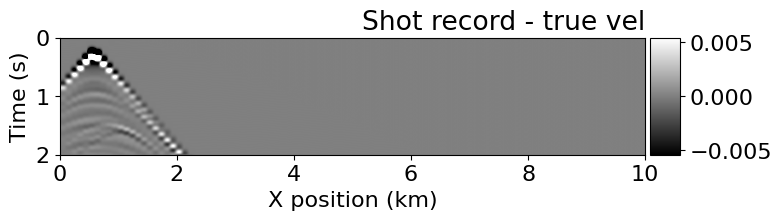

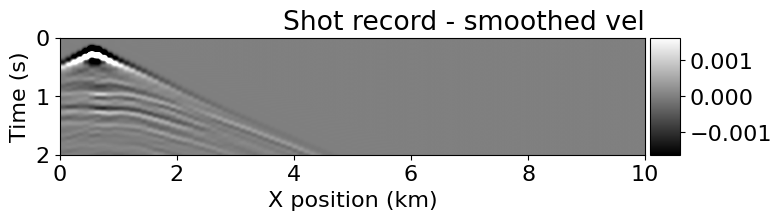

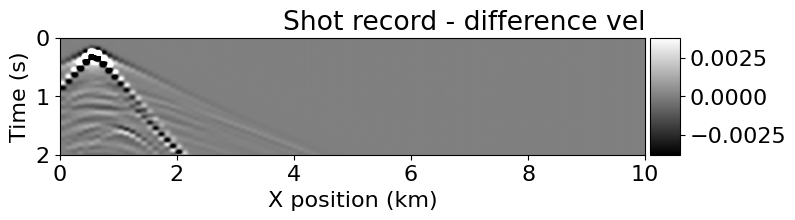

In [184]:
plt.title('Shot record - true vel', loc='right')
plot_shotrecord(p_r, model, d0, tf) # In reality, this would be our data from the experiment
plt.title('Shot record - smoothed vel', loc='right')
plot_shotrecord(p_r_guess, model, d0, tf) # In reality, this would be our data from the experiment
plt.title('Shot record - difference vel', loc='right')
plot_shotrecord(p_r_guess - p_r, model, d0, tf) # In reality, this would be our data from the experiment

### 2.4.5 Between different velocity but i bluered the velocity direclty at the end (do not think think this is correct)

In [303]:
from scipy.ndimage import gaussian_filter
# 应用高斯模糊
sigma = 1  # 高斯核的标准差，控制模糊程度
p_r_blurred = gaussian_filter(p_r, sigma=sigma)

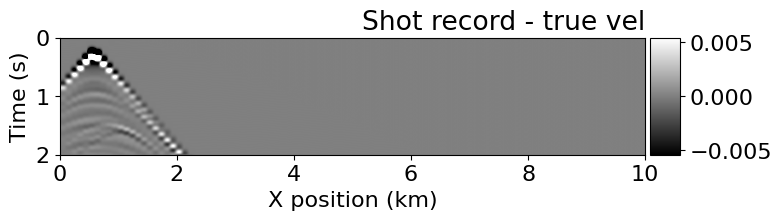

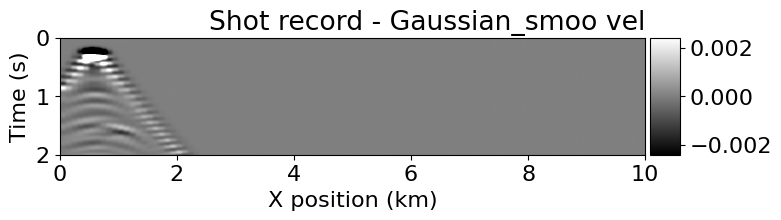

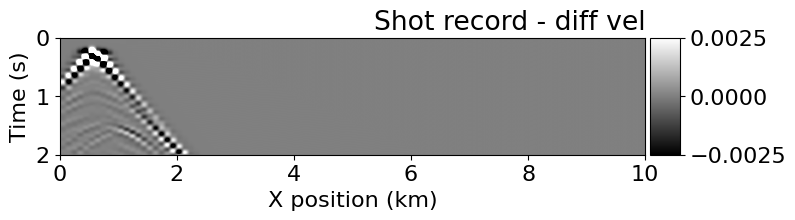

In [327]:
plt.title('Shot record - true vel', loc='right')
plot_shotrecord(p_r, model, d0, tf) # In reality, this would be our data from the experiment
plt.title('Shot record - Gaussian_smoo vel', loc='right')
plot_shotrecord(p_r_blurred, model, d0, tf) # In reality, this would be our data from the experiment
plt.title('Shot record - diff vel', loc='right')
plot_shotrecord(p_r_blurred - p_r, model, d0, tf) # In reality, this would be our data from the experimentv

### some other visualisation

In [158]:
# import matplotlib.pyplot as plt 

# # Plotting
# fig, ax = plt.subplots()
# ax.plot(*zip(*sou), 'ro', label='Source')  # red dot for source
# ax.plot(*zip(*rev), 'bs', label='Receivers')  # blue squares for receivers
# # Setting the axis limits to match the example
# ax.set_xlim(-0.5, 14)
# ax.set_ylim(-0.5, 5)
# # Adding labels
# ax.set_xlabel('X position')
# ax.set_ylabel('Y position')
# ax.set_title('Source and Receiver Positions')

# plt.show()

## 2.4.6 Using different mesh (resolutions)

In [323]:
number_sou = 3
number_rec = 101
sou = spyro.create_transect((-0.01, 1.0), (-0.01, 15.0), 3) # in km
rev = spyro.create_transect((-0.10, 0.1), (-0.10, 17.0), 101)  # in km

model = {}

model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadrature": "KMV",  # Equi or KMV
    "degree": 5,  # p order
    "dimension": 2,  # dimension
}
model["parallelism"] = {
    "type": "spatial",
}
model["mesh"] = {
    "Lz": 3.5,  # depth in km - always positive
    "Lx": 10.0,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "/Users/yw11823/ACSE/irp/spyro/meshes/marmousi_exact.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5",
}
model["BCs"] = {
    "status": True,  # True or false
    "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": number_sou,
    "source_pos": sou,
    "frequency": 5.0,
    "delay": 1.0,
    "num_receivers": number_rec,
    "receiver_locations": rev,
}
model["timeaxis"] = {
    "t0": 0.0,  # Initial time for event
    "tf": 2.00,  # Final time for event
    "dt": 0.00025,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 99999,  # how frequently to save solution to RAM
}

In [324]:
comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)
vp = spyro.io.interpolate(model, mesh, V, guess=False)
if comm.ensemble_comm.rank == 0:
    File("true_velocity_lowresol.pvd", comm=comm.comm).write(vp)
sources = spyro.Sources(model, mesh, V, comm)
receivers = spyro.Receivers(model, mesh, V, comm)

dt=model["timeaxis"]["dt"]
tf=model["timeaxis"]["tf"]
freq=model["acquisition"]["frequency"]
wavelet = spyro.full_ricker_wavelet(dt=dt,tf=tf,freq=freq,)

start_time = time.time()
p, p_r_lowresol = spyro.solvers.forward(model, mesh, comm, vp, sources, wavelet, receivers)
end_time = time.time()
running_time = end_time - start_time
print("Running Time: {:.2f} seconds".format(running_time))

# Plot the shot record using the function written in Spyro
spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-5, vmax=1e-5, file_name = "M2d_lowresol")
# spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-3, vmax=1e-3)
spyro.io.save_shots(model, comm, p_r, file_name="M2d-lowresol")

INFO: Distributing 3 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 4866 elements and can access 2550 vertices


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/interpolation.py:385: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


INFO: converting from m/s to km/s


/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/Users/yw11823/ACSE/irp/firedrake/src/firedrake/firedrake/function.py:325: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value).__name__}, "
/Users/yw11823/ACSE/irp/firedrake/src/ufl/ufl/utils/sorting.py:84: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn(f"Applying str() to a metadata value of type {type(value)._

Simulation time is:    0.02475 seconds
Simulation time is:    0.04975 seconds
Simulation time is:    0.07475 seconds
Simulation time is:    0.09975 seconds
Simulation time is:     0.1247 seconds
Simulation time is:     0.1497 seconds
Simulation time is:     0.1748 seconds
Simulation time is:     0.1998 seconds
Simulation time is:     0.2248 seconds
Simulation time is:     0.2497 seconds
Simulation time is:     0.2747 seconds
Simulation time is:     0.2998 seconds
Simulation time is:     0.3247 seconds
Simulation time is:     0.3498 seconds
Simulation time is:     0.3748 seconds
Simulation time is:     0.3997 seconds
Simulation time is:     0.4248 seconds
Simulation time is:     0.4497 seconds
Simulation time is:     0.4748 seconds
Simulation time is:     0.4998 seconds
Simulation time is:     0.5248 seconds
Simulation time is:     0.5497 seconds
Simulation time is:     0.5747 seconds
Simulation time is:     0.5998 seconds
Simulation time is:     0.6248 seconds
Simulation time is:     0

### Plot the graph between diff resolutions

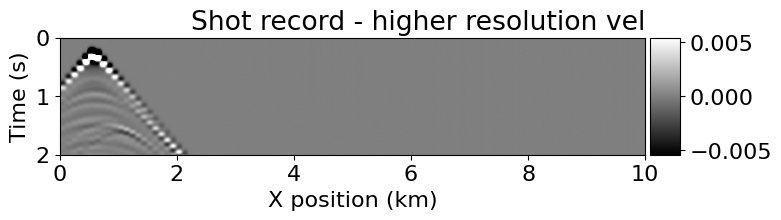

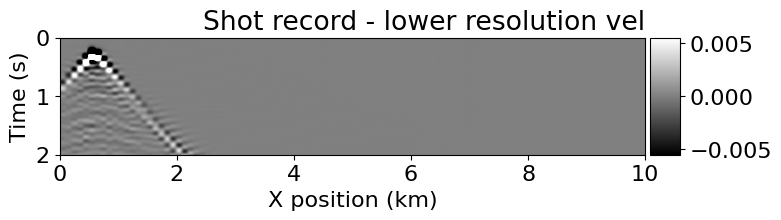

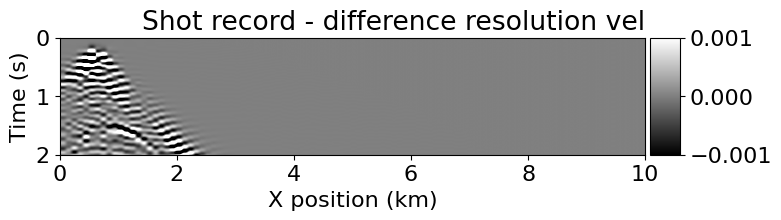

In [326]:
plt.title('Shot record - higher resolution vel', loc='right')
plot_shotrecord(p_r, model, d0, tf) 
plt.title('Shot record - lower resolution vel', loc='right')
plot_shotrecord(p_r_lowresol, model, d0, tf) 
plt.title('Shot record - difference resolution vel', loc='right')
plot_shotrecord(p_r_lowresol - p_r, model, d0, tf) 

# Marmousi - spyro - 3d - true
Runned the following in py file direclty. 

load the data here to plot the record graph

In [325]:
# line1 = spyro.create_transect((0.25, 0.25), (0.25, 7.25), 4)
# line2 = spyro.create_transect((2.0, 0.25), (2.0, 7.25), 4)
# line3 = spyro.create_transect((3.75, 0.25), (3.75, 7.25), 4)
# line4 = spyro.create_transect((5.5, 0.25), (5.25, 7.25), 4)
# line5 = spyro.create_transect((7.25, 0.25), (7.25, 7.25), 4)
# lines = np.concatenate((line1, line2, line3, line4, line5))

# sources = spyro.insert_fixed_value(lines, -0.10, 0)

# receivers = spyro.create_2d_grid(0.25, 7.25, 0.25, 7.25, 30)
# receivers = spyro.insert_fixed_value(receivers, -0.15, 0)

# model = {}

# model["opts"] = {
#     "method": "KMV",  # either CG or KMV
#     "quadrature": "KMV",  # Equi or KMV
#     "degree": 3,  # p order
#     "dimension": 3,  # dimension
# }
# model["parallelism"] = {"type": "spatial"}  # automatic",
# model["mesh"] = {
#     "Lz": 5.175,  # depth in km - always positive
#     "Lx": 7.50,  # width in km - always positive
#     "Ly": 7.50,  # thickness in km - always positive
#     "meshfile": "/Users/yw11823/ACSE/irp/spyro/FWI_3D_DATA/meshes/overthrust_3D_true_model.msh",
#     "initmodel": "/Users/yw11823/ACSE/irp/spyro/FWI_3D_DATA/velocity_models/overthrust_3D_guess_model.hdf5",
#     "truemodel": "/Users/yw11823/ACSE/irp/spyro/FWI_3D_DATA/velocity_models/overthrust_3D_true_model.hdf5",
# }
# model["BCs"] = {
#     "status": True,  # True or false
#     "outer_bc": "non-reflective",  # None or non-reflective (outer boundary condition)
#     "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
#     "exponent": 2,  # damping layer has a exponent variation
#     "cmax": 6.0,  # maximum acoustic wave velocity in PML - km/s
#     "R": 1e-6,  # theoretical reflection coefficient
#     "lz": 0.75,  # thickness of the PML in the z-direction (km) - always positive
#     "lx": 0.75,  # thickness of the PML in the x-direction (km) - always positive
#     "ly": 0.75,  # thickness of the PML in the y-direction (km) - always positive
# }
# model["acquisition"] = {
#     "source_type": "Ricker",
#     "num_sources": len(sources),
#     "source_pos": sources,
#     "frequency": 5.0,
#     "delay": 1.0,
#     "num_receivers": len(receivers),
#     "receiver_locations": receivers,
# }
# model["timeaxis"] = {
#     "t0": 0.0,  # Initial time for event
#     "tf": 4.00,  # Final time for event
#     "dt": 0.00075,
#     "amplitude": 1,  # the Ricker has an amplitude of 1.
#     "nspool": 1000,  # how frequently to output solution to pvds
#     "fspool": 99999,  # how frequently to save solution to RAM
# }
# comm = spyro.utils.mpi_init(model)
# mesh, V = spyro.io.read_mesh(model, comm)
# vp = spyro.io.interpolate(model, mesh, V, guess=False)
# if comm.ensemble_comm.rank == 0:
#     File("true_velocity.pvd", comm=comm.comm).write(vp)
# sources = spyro.Sources(model, mesh, V, comm)
# receivers = spyro.Receivers(model, mesh, V, comm)
# wavelet = spyro.full_ricker_wavelet(
#     dt=model["timeaxis"]["dt"],
#     tf=model["timeaxis"]["tf"],
#     freq=model["acquisition"]["frequency"],
# )
# t1 = time.time()
# p, p_r = spyro.solvers.forward(
#     model, mesh, comm, vp, sources, wavelet, receivers, output=False
# )
# print(time.time() - t1, flush=True)
# spyro.plots.plot_shots(model, comm, p_r, vmin=-1e-3, vmax=1e-3)


# generated the true velocity model in paraview
# should have the data file but accidently deleted and i do not have more time to generated again